In [1]:
import nocd
import matplotlib.pyplot as plt
import numpy as np
import scipy.sparse as sp
import torch
import torch.nn as nn
import torch.nn.functional as F


from sklearn.preprocessing import normalize
from scipy.sparse import csr_matrix
import pandas as pd

import dgl
import numpy as np
import torch as th
from dgl.nn import EdgeGATConv

%matplotlib inline

# torch.set_default_tensor_type(torch.cuda.FloatTensor)

In [2]:
import pickle
with open('subgraph.pkl', 'rb') as file:
    subgraph = pickle.load(file)

In [3]:
subgraph.ndata['feature']=subgraph.ndata['feature'].to(torch.float)
subgraph.edata['feature']=subgraph.edata['feature'].to(torch.float)

In [5]:
import networkx as nx
G=dgl.to_networkx(subgraph)
A=nx.to_scipy_sparse_matrix(G, format='csr')
A

<10693x10693 sparse matrix of type '<class 'numpy.intc'>'
	with 1458949 stored elements in Compressed Sparse Row format>

In [6]:
from scipy.sparse import csr_matrix
X=csr_matrix(subgraph.ndata['feature'].cpu().numpy())
X

<10693x112 sparse matrix of type '<class 'numpy.float32'>'
	with 173392 stored elements in Compressed Sparse Row format>

In [7]:
df = pd.read_csv('./dataset/ogbn_proteins/raw/node_species.csv.gz', header=None, names=['species_id'])
selected_species=[4932,511145]
df_selected_species = df[df['species_id'].isin(selected_species)]
affiliation_matrix = pd.get_dummies(df_selected_species, columns=['species_id']).groupby(level=0, axis=1).max()


C:\Users\ACT\AppData\Local\Temp\ipykernel_11992\996842585.py:4: FutureWarning: DataFrame.groupby with axis=1 is deprecated. Do `frame.T.groupby(...)` without axis instead.
  affiliation_matrix = pd.get_dummies(df_selected_species, columns=['species_id']).groupby(level=0, axis=1).max()


In [8]:
Z_gt=affiliation_matrix.astype('int').values
orG = G
N, K = Z_gt.shape

In [23]:
in_feats=112
edge_feats=8
out_feats=2
num_heads=1
feat_drop=0.5
attn_drop=0.5
negative_slope=0.2
residual=True
activation=F.relu
allow_zero_in_degree=True
bias=False
hidden_feats = [128]

In [24]:
hidden_sizes = [128]    # hidden sizes of the GNN
weight_decay = 1e-2     # strength of L2 regularization on GNN weights
dropout = 0.5           # whether to use dropout
batch_norm = True       # whether to use batch norm
lr = 1e-3               # learning rate
max_epochs = 500        # number of epochs to train
display_step = 25       # how often to compute validation loss
balance_loss = True     # whether to use balanced loss
stochastic_loss = True  # whether to use stochastic or full-batch training
batch_size = 20000     # batch size (only for stochastic training)

In [11]:
x_norm = normalize(X)  # node features
# x_norm = normalize(A)  # adjacency matrix
# x_norm = sp.hstack([normalize(X), normalize(A)])  # concatenate A and X
x_norm = nocd.utils.to_sparse_tensor(x_norm)

c:\Users\ACT\Desktop\nocd-modified\nocd\utils.py:35: UserWarning: torch.sparse.SparseTensor(indices, values, shape, *, device=) is deprecated.  Please use torch.sparse_coo_tensor(indices, values, shape, dtype=, device=). (Triggered internally at C:\cb\pytorch_1000000000000\work\torch\csrc\utils\tensor_new.cpp:620.)
  sparse_tensor = torch.sparse.FloatTensor(indices, values, shape)


In [25]:
sampler = nocd.sampler.get_edge_sampler(A, batch_size, batch_size, num_workers=5)
gnn = nocd.nn.EGCN(in_feats,
        edge_feats,
        hidden_sizes,
        out_feats,
        num_heads,
        feat_drop,
        attn_drop,
        negative_slope,
        residual,
        activation,
        allow_zero_in_degree,
        bias,
        dropout, 
        batch_norm)
adj_norm = gnn.normalize_adj(A)
decoder = nocd.nn.BerpoDecoder(N, A.nnz, balance_loss=balance_loss)
opt = torch.optim.Adam(gnn.parameters(), lr=lr)

In [ ]:
graph=subgraph.to('cuda')
node_feats=subgraph.ndata['feature'].cuda()
edge_feats=subgraph.edata['feature'].cuda()

In [31]:
graph=subgraph
node_feats=subgraph.ndata['feature']
edge_feats=subgraph.edata['feature']

In [32]:
node_feats=F.normalize(node_feats)
edge_feats=F.normalize(edge_feats)

In [27]:
def get_nmi(thresh=0.5):
    """Compute Overlapping NMI of the communities predicted by the GNN."""
    gnn.eval()
    Z = F.relu(gnn(graph, node_feats, edge_feats))
    Z=Z.reshape(Z.shape[0],Z.shape[3])
    Z_pred = Z.cpu().detach().numpy() > thresh
    nmi = nocd.metrics.overlapping_nmi(Z_pred, Z_gt)
    return nmi

In [36]:
Z = F.relu(gnn(graph, node_feats, edge_feats))
Z.shape

torch.Size([10693, 1, 1, 2])

In [37]:
Z=Z.reshape(Z.shape[0],Z.shape[3])
val_loss = decoder.loss_full(Z, A)
print(f'Epoch {epoch:4d}, loss.full = {val_loss:.4f}, nmi = {get_nmi():.4f}')

Epoch   53, loss.full = 2.1800, nmi = 0.0043


In [38]:
val_loss = np.inf
validation_fn = lambda: val_loss
early_stopping = nocd.train.NoImprovementStopping(validation_fn, patience=10)
model_saver = nocd.train.ModelSaver(gnn)

for epoch, batch in enumerate(sampler):
    if epoch > max_epochs:
        break
    if epoch % 25 == 0:
        with torch.no_grad():
            gnn.eval()
            # Compute validation loss
            Z = F.relu(gnn(graph, node_feats, edge_feats))
            Z=Z.reshape(Z.shape[0],Z.shape[3])
            val_loss = decoder.loss_full(Z, A)
            print(f'Epoch {epoch:4d}, loss.full = {val_loss:.4f}, nmi = {get_nmi():.4f}')
            
            # Check if it's time for early stopping / to save the model
            early_stopping.next_step()
            if early_stopping.should_save():
                model_saver.save()
            if early_stopping.should_stop():
                print(f'Breaking due to early stopping at epoch {epoch}')
                break
            
    # Training step
    gnn.train()
    opt.zero_grad()
    Z = F.relu(gnn(graph, node_feats, edge_feats))
    Z=Z.reshape(Z.shape[0],Z.shape[3])
    ones_idx, zeros_idx = batch
    if stochastic_loss:
        loss = decoder.loss_batch(Z, ones_idx, zeros_idx)
    else:
        loss = decoder.loss_full(Z, A)
    loss += nocd.utils.l2_reg_loss(gnn, scale=weight_decay)
    loss.backward()
    opt.step()

Epoch    0, loss.full = 2.1800, nmi = 0.0043
Epoch   25, loss.full = 2.4351, nmi = 0.4933
Epoch   50, loss.full = 1.8928, nmi = 0.8983
Epoch   75, loss.full = 0.7345, nmi = 0.8869
Epoch  100, loss.full = 0.6052, nmi = 0.8973
Epoch  125, loss.full = 0.5732, nmi = 0.8952
Epoch  150, loss.full = 0.5758, nmi = 0.8964
Epoch  175, loss.full = 0.5601, nmi = 0.8967
Epoch  200, loss.full = 0.5354, nmi = 0.8967
Epoch  225, loss.full = 0.5376, nmi = 0.8956
Epoch  250, loss.full = 0.5347, nmi = 0.8943
Epoch  275, loss.full = 0.5197, nmi = 0.8940
Epoch  300, loss.full = 0.5071, nmi = 0.8904
Epoch  325, loss.full = 0.5155, nmi = 0.8925
Epoch  350, loss.full = 0.4967, nmi = 0.8901
Epoch  375, loss.full = 0.5098, nmi = 0.8892
Epoch  400, loss.full = 0.5015, nmi = 0.8882
Epoch  425, loss.full = 0.4863, nmi = 0.8837
Epoch  450, loss.full = 0.4904, nmi = 0.8845
Epoch  475, loss.full = 0.4911, nmi = 0.8846
Epoch  500, loss.full = 0.4787, nmi = 0.8782


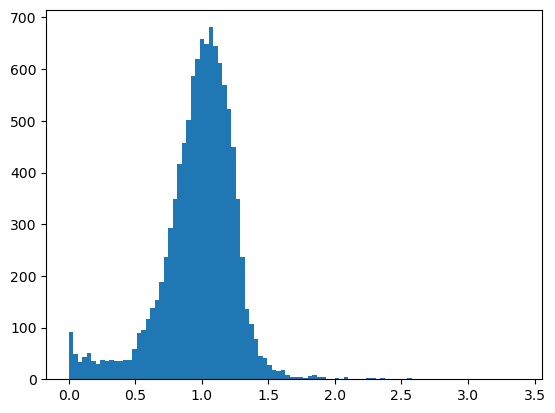

In [39]:
plt.hist(Z[Z > 0].cpu().detach().numpy(), 100);

In [41]:
thresh = 0.5

Z = F.relu(gnn(graph, node_feats, edge_feats))
Z=Z.reshape(Z.shape[0],Z.shape[3])
Z_pred = Z.cpu().detach().numpy() > thresh
model_saver.restore()
print(f'Final nmi = {get_nmi(thresh):.3f}')

Final nmi = 0.878


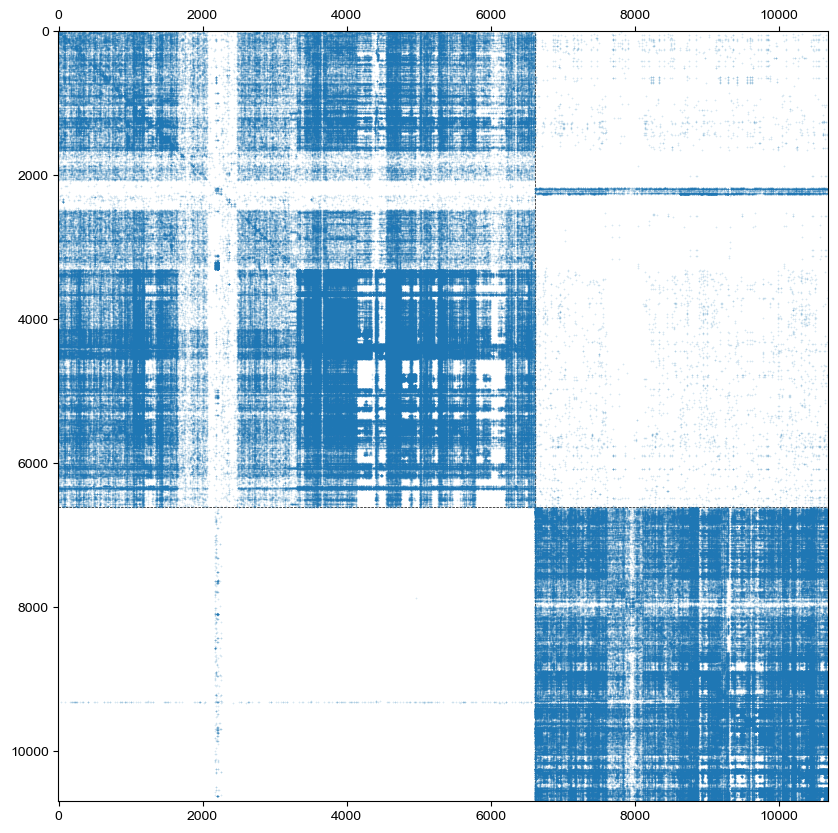

In [42]:
plt.figure(figsize=[10, 10])
z = np.argmax(Z_pred, 1)
o = np.argsort(z)
nocd.utils.plot_sparse_clustered_adjacency(A, K, z, o, markersize=0.05)

In [43]:
# Sizes of detected communities
print(Z_pred.sum(0))

[6031 4096]


In [44]:
metrics = nocd.metrics.evaluate_unsupervised(Z_gt, A)
print(f"Ground truth communities:\n"
      f" - coverage    = {metrics['coverage']:.4f}\n"
      f" - conductance = {metrics['conductance']:.4f}\n"
      f" - density     = {metrics['density']:.3e}\n"
      f" - clust_coef  = {metrics['clustering_coef']:.3e}")

c:\Users\ACT\Desktop\nocd-modified\nocd\metrics\unsupervised.py:29: RuntimeWarning: overflow encountered in scalar multiply
  possible = (n - 2) * (n - 1) * n / 6


Ground truth communities:
 - coverage    = 0.9962
 - conductance = 0.0040
 - density     = 2.517e-02
 - clust_coef  = 0.000e+00


In [45]:
metrics = nocd.metrics.evaluate_unsupervised(Z_pred, A)
print(f"Predicted communities:\n"
      f" - coverage    = {metrics['coverage']:.4f}\n"
      f" - conductance = {metrics['conductance']:.4f}\n"
      f" - density     = {metrics['density']:.3e}\n"
      f" - clust_coef  = {metrics['clustering_coef']:.3e}")

Predicted communities:
 - coverage    = 0.9803
 - conductance = 0.0165
 - density     = 2.747e-02
 - clust_coef  = 0.000e+00


In [46]:
Z_gt

array([[1, 0],
       [1, 0],
       [1, 0],
       ...,
       [0, 1],
       [0, 1],
       [0, 1]])

In [47]:
Z_pred

array([[False, False],
       [False, False],
       [ True, False],
       ...,
       [False,  True],
       [False,  True],
       [False, False]])

In [48]:
def get_comlist(community_matrix):
    transposed_matrix = np.transpose(community_matrix)

    # Initialize an empty list to store tuples (community_id, nodes_list)
    community_nodes_list = []

    # Iterate through rows (communities)
    for community_id, community_row in enumerate(transposed_matrix):
        # Find nodes (columns) where the value is 1
        community_nodes = np.where(community_row == 1)[0].tolist()
        
        # Append a tuple to the list containing community ID and nodes list
        community_nodes_list.append(community_nodes)
    
    return community_nodes_list

In [49]:
from cdlib import NodeClustering
from cdlib import evaluation

coms1=get_comlist(Z_gt)
coms2=get_comlist(Z_pred)

communities1=NodeClustering(coms1,G)
communities2=NodeClustering(coms2,G)

onmi=evaluation.overlapping_normalized_mutual_information_LFK(communities1,communities2)
print(onmi)

MatchingResult(score=0.8281890828225472, std=None)
